In [41]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [42]:
TRAIN_DATA_PATH = "./data-collection/train/"
TEST_DATA_PATH = "./data-collection/test/"
TRANSFORM_IMG = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(28),
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,), std=(0.229, ))
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

In [35]:
BATCH_SIZE = 20
LEARNING_RATE = 0.001

In [36]:
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_data_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 
img =next(iter(train_data_loader))
img[0].shape

torch.Size([20, 1, 28, 28])

In [5]:
class my_network_batch_normalization(nn.Module):
    
    # Contructor
    def __init__(self, out_1=8, out_2=16,number_of_classes=4):
        super(my_network_batch_normalization, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        
        self.fc2 = nn.Linear(64, number_of_classes)
        self.bn_fc2 = nn.BatchNorm1d(4)
    
    # Prediction
    def forward(self, x):
#         print(x.shape)
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.fc2(x)
        x = self.bn_fc2(x)
        return x

In [37]:
def train_model(model,n_epochs,train_loader,validation_loader,optimizer):
    
    #global variable 
    N_test=len(test_data)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        total_loss = 0
        count = 0
        for x, y in train_loader:
            count += 1
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_list.append(total_loss/len(train_loader))
        

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            count +=1
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
#         print('Epoch: ', epoch, 'Loss: ', total_loss/len(train_loader), 'Accuracy: ', accuracy)
     
    return accuracy_list, loss_list

In [7]:
# Create the model object using CNN class
model = my_network_batch_normalization(out_1=8, out_2=16)

In [9]:
model.parameters

<bound method Module.parameters of my_network_batch_normalization(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (bn_fc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (bn_fc2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.6)

In [15]:
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=15,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer)
print('Finished')

Epoch:  0 Loss:  0.5153354769029455 Accuracy:  0.924775928297055
Epoch:  1 Loss:  0.36536597040817037 Accuracy:  0.9311779769526248
Epoch:  2 Loss:  0.3106523905039512 Accuracy:  0.9366197183098591
Epoch:  3 Loss:  0.27953578694955383 Accuracy:  0.9401408450704225
Epoch:  4 Loss:  0.2636063571802074 Accuracy:  0.940460947503201
Epoch:  5 Loss:  0.24710593284087873 Accuracy:  0.941741357234315
Epoch:  6 Loss:  0.2387533326067592 Accuracy:  0.9407810499359796
Epoch:  7 Loss:  0.22837401791389603 Accuracy:  0.9407810499359796
Epoch:  8 Loss:  0.22211406839372932 Accuracy:  0.9436619718309859
Epoch:  9 Loss:  0.21515273586297104 Accuracy:  0.9436619718309859
Epoch:  10 Loss:  0.20915394974541274 Accuracy:  0.9433418693982074
Epoch:  11 Loss:  0.20842714237836144 Accuracy:  0.9439820742637645
Epoch:  12 Loss:  0.20217741491699626 Accuracy:  0.9446222791293214
Epoch:  13 Loss:  0.19892115673980282 Accuracy:  0.9439820742637645
Epoch:  14 Loss:  0.1967593248149282 Accuracy:  0.941421254801536

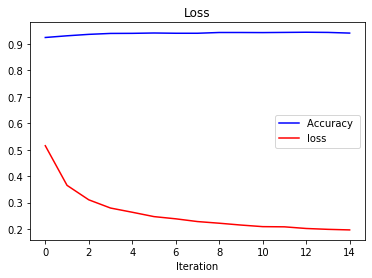

In [17]:
# Plot the loss and accuracy
plt.plot(accuracy_list_normal, 'b', label='Accuracy ')
plt.plot(loss_list_normal, 'r', label='loss')
plt.xlabel('Iteration')
plt.title("Loss")
plt.legend()

# only cnn and linear

In [43]:
class my_network_cnn_linear(nn.Module):
    
    # Contructor
    def __init__(self, out_1=8, out_2=16,number_of_classes=4):
        super(my_network_cnn_linear, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(out_2 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [22]:
avg_acc = []
avg_loss = []
#call the model
for i in range(10):
    model2 = my_network_cnn_linear(out_1=8, out_2=16)

#define loss and optimization
    criterion = nn.CrossEntropyLoss()
    optimizer2 = torch.optim.Adam(model2.parameters(), lr = LEARNING_RATE)

#run the model
    accuracy_list_normal, loss_list_normal=train_model(model=model2,n_epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer2)
    avg_acc.append(accuracy_list_normal[-1])
    avg_loss.append(loss_list_normal[-1])
    print('Finished ', i)

#plot the graph
# plt.plot(accuracy_list_normal, 'b', label='Accuracy ')
# plt.plot(loss_list_normal, 'r', label='loss')
# plt.xlabel('Iteration')
# plt.title("Loss")
# plt.legend()

Epoch:  0 Loss:  0.3818625893396131 Accuracy:  0.9206145966709347
Epoch:  1 Loss:  0.2441898523319836 Accuracy:  0.9337387964148528
Epoch:  2 Loss:  0.2188479796364628 Accuracy:  0.9407810499359796
Epoch:  3 Loss:  0.20388947929630577 Accuracy:  0.9350192061459667
Epoch:  4 Loss:  0.1954925341642916 Accuracy:  0.9362996158770807
Epoch:  5 Loss:  0.19073868595503515 Accuracy:  0.9388604353393086
Epoch:  6 Loss:  0.18699035540310557 Accuracy:  0.9379001280409731
Epoch:  7 Loss:  0.18017164048699696 Accuracy:  0.9375800256081946
Epoch:  8 Loss:  0.17654209075413463 Accuracy:  0.9401408450704225
Epoch:  9 Loss:  0.17163366495842275 Accuracy:  0.9401408450704225
Finished  0
Epoch:  0 Loss:  0.40612392794409735 Accuracy:  0.8950064020486556
Epoch:  1 Loss:  0.2419206418830949 Accuracy:  0.9222151088348272
Epoch:  2 Loss:  0.2278518142035578 Accuracy:  0.9366197183098591
Epoch:  3 Loss:  0.21274804412407183 Accuracy:  0.9391805377720871
Epoch:  4 Loss:  0.20128685082964715 Accuracy:  0.941421

In [23]:
import numpy as np

for loss, acc in zip(avg_loss, avg_acc):
    print('Training Loss: ', loss, 'Validation Accuracy: ', acc)

Training Loss:  0.17163366495842275 Validation Accuracy:  0.9401408450704225
Training Loss:  0.18125529272434107 Validation Accuracy:  0.9433418693982074
Training Loss:  0.17947647900480887 Validation Accuracy:  0.941101152368758
Training Loss:  0.17333862890892132 Validation Accuracy:  0.9407810499359796
Training Loss:  0.1706921719458447 Validation Accuracy:  0.941101152368758
Training Loss:  0.16883319208880682 Validation Accuracy:  0.9433418693982074
Training Loss:  0.17553775202202085 Validation Accuracy:  0.9420614596670934
Training Loss:  0.17333933516308814 Validation Accuracy:  0.9420614596670934
Training Loss:  0.1649781122338689 Validation Accuracy:  0.9436619718309859
Training Loss:  0.16881746918514137 Validation Accuracy:  0.9427016645326505


In [24]:
print('Average training loss: ', np.mean(avg_loss))
print('Average validation accuracy: ', np.mean(avg_acc))

Average training loss:  0.1727902098235265
Average validation accuracy:  0.9420294494238156


# cnn and rnn together

In [48]:
class my_network_cnn_linear(nn.Module):
    
    # Contructor
    def __init__(self, out_1=4, hidden_size=128, num_layers=2, number_of_classes=4):
        super(my_network_cnn_linear, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.rnn = nn.LSTM(out_1*14, 128, 2, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, number_of_classes)
    
    # Prediction
    def forward(self, x):
        
#         h0 = torch.zeros(2, x.size(0), 128)
        
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = x.view(x.size(0), 14, -1)
        
        x, (h_n, h_c) = self.rnn(x) 
        x = self.fc(x[:, -1, :])
        
        return x

Epoch:  0 Loss:  1.0733347123920662 Accuracy:  0.7701664532650448
Epoch:  1 Loss:  0.6775189662937758 Accuracy:  0.7701664532650448
Epoch:  2 Loss:  0.5488767702328531 Accuracy:  0.83898847631242
Epoch:  3 Loss:  0.43143627707810694 Accuracy:  0.852112676056338
Epoch:  4 Loss:  0.38541938140882365 Accuracy:  0.8642765685019206
Epoch:  5 Loss:  0.3597591952453891 Accuracy:  0.8825224071702945
Epoch:  6 Loss:  0.3369324607125472 Accuracy:  0.8793213828425096
Epoch:  7 Loss:  0.3154317510750139 Accuracy:  0.9007682458386683
Epoch:  8 Loss:  0.30130079273097377 Accuracy:  0.8703585147247119
Epoch:  9 Loss:  0.28525241229889825 Accuracy:  0.9126120358514724
Finished


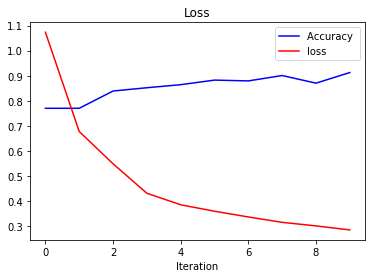

In [49]:
#call the model
model3 = my_network_cnn_linear(out_1=4, num_layers=2)

#define loss and optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr = LEARNING_RATE, momentum=0.7)

#run the model
accuracy_list_normal, loss_list_normal=train_model(model=model3,n_epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer)
print('Finished')

#plot the graph
plt.plot(accuracy_list_normal, 'b', label='Accuracy ')
plt.plot(loss_list_normal, 'r', label='loss')
plt.xlabel('Iteration')
plt.title("Loss")
plt.legend()

# hyerparameter optimization

In [39]:
for layer in [[4,8], [8, 16], [16,32]]:
    for lrr in [0.1, 0.01, 0.001]:
        print(layer, ' : ', lrr)
        model2 = my_network_cnn_linear(out_1=layer[0], out_2=layer[1])

    #define loss and optimization
        criterion = nn.CrossEntropyLoss()
        optimizer2 = torch.optim.Adam(model2.parameters(), lr = lrr)

    #run the model
        accuracy_list_normal, loss_list_normal=train_model(model=model2,n_epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer2)
        print('CNN Layer: ', layer, 'Learning Rate: ', lr, 'Loss: ', loss_list_normal[-1], 'Acc:', accuracy_list_normal[-1])

[4, 8]  :  0.1
CNN Layer:  [4, 8] Learning Rate:  0.1 Loss:  1.2244592910555654 Acc: 0.4801536491677337
[4, 8]  :  0.01
CNN Layer:  [4, 8] Learning Rate:  0.1 Loss:  0.29467898015937055 Acc: 0.9154929577464789
[4, 8]  :  0.001
CNN Layer:  [4, 8] Learning Rate:  0.1 Loss:  0.20088216954919047 Acc: 0.9379001280409731
[8, 16]  :  0.1
CNN Layer:  [8, 16] Learning Rate:  0.1 Loss:  1.233787413808394 Acc: 0.4801536491677337
[8, 16]  :  0.01
CNN Layer:  [8, 16] Learning Rate:  0.1 Loss:  0.2605487664520295 Acc: 0.9222151088348272
[8, 16]  :  0.001
CNN Layer:  [8, 16] Learning Rate:  0.1 Loss:  0.16404809163993286 Acc: 0.9372599231754162
[16, 32]  :  0.1
CNN Layer:  [16, 32] Learning Rate:  0.1 Loss:  1.2277144726106146 Acc: 0.4801536491677337
[16, 32]  :  0.01
CNN Layer:  [16, 32] Learning Rate:  0.1 Loss:  1.1957400786249262 Acc: 0.4801536491677337
[16, 32]  :  0.001
CNN Layer:  [16, 32] Learning Rate:  0.1 Loss:  0.16106293198240557 Acc: 0.9433418693982074


In [44]:
for batch_s in [20, 30, 40]:
    for lrr in [0.001, 0.0001]:
        
        train_data_loader = data.DataLoader(train_data, batch_size=batch_s, shuffle=True,  num_workers=2)
        test_data_loader  = data.DataLoader(test_data, batch_size=batch_s, shuffle=True, num_workers=2) 
        
        model2 = my_network_cnn_linear(out_1=16, out_2=32)

    #define loss and optimization
        criterion = nn.CrossEntropyLoss()
        optimizer2 = torch.optim.Adam(model2.parameters(), lr = lrr)

    #run the model
        accuracy_list_normal, loss_list_normal=train_model(model=model2,n_epochs=10,train_loader=train_data_loader,validation_loader=test_data_loader,optimizer=optimizer2)
        print('Batch Size: ', batch_s, 'Learning Rate: ', lrr, 'Loss: ', loss_list_normal[-1], 'Acc:', accuracy_list_normal[-1])

Batch Size:  20 Learning Rate:  0.001 Loss:  0.15951046246007233 Acc: 0.9465428937259923
Batch Size:  20 Learning Rate:  0.0001 Loss:  0.21320020057033126 Acc: 0.9362996158770807
Batch Size:  30 Learning Rate:  0.001 Loss:  0.15479840741836345 Acc: 0.9420614596670934
Batch Size:  30 Learning Rate:  0.0001 Loss:  0.22795876248408037 Acc: 0.9346991037131882
Batch Size:  40 Learning Rate:  0.001 Loss:  0.1647528470579964 Acc: 0.9395006402048656
Batch Size:  40 Learning Rate:  0.0001 Loss:  0.21233150203464551 Acc: 0.9366197183098591
